In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import os
pd.set_option('display.max_rows', 5000)
import numpy as np
import statistics
import itertools
import math

In [9]:
def obereKante(x):
    ObereKante = 0.009*x+4.267
    return(ObereKante)

def obereKante_flaeche(x):
    ObereKante = 0.009*x+3.55
    return(ObereKante)

def untereKante(x):
    UntereKante = -0.003*x+0.264
    return(UntereKante)

def leftBorder(x):
    leftBorder = x-2.5
    return(leftBorder)

def rightBorder(x):
    rightBorder = x+2.5
    return(rightBorder)

def bottomBorder(x):
    bottomBorder = obereKante_flaeche(x)
    return(bottomBorder)

def plotBahnsteig():
    geo = pd.read_csv( "../Daten ZHDB/geo_ZHDB.txt", skiprows = 2, sep = " ", names = ["x", "y", "obj"])
    for obj in geo["obj"].unique():
        plt.plot(geo.loc[geo["obj"] == obj]["x"], geo.loc[geo["obj"] == obj]["y"], color = "black", linewidth = 0.75)
        plt.axis("equal")

        
def getDistance(x1, x2, y1, y2):
    result = math.sqrt((x2 -x1)**2 + (y2 - y1)**2)
    return(result)

In [10]:
distance_in_area = []
distance_out_area = []
keep_distance = []
filenames = []
enterTimeAll = []
enterTimeAverage = []

In [11]:
#Jede File in Pfadangabe
for filename in os.listdir(r"C:\Users\robin\Documents\Bachelorarbeit\Daten ZHDB"):    
    if "txt" in filename and "geo" not in filename:
        filenames.append(filename)
        #Daten einlesen
        data = pd.read_csv("../Daten ZHDB/" + filename, skiprows = 4, sep = "\t", names = ["id", "frame", "x/m", "y/m", "h/m"])
        #Nur die Sterbeframes
        sample = data.groupby("id").last()
#         print(filename)
        #Check welche Personen an unterer Gleiskante sterben
        sample["YMin"] = list(map(untereKante, sample["x/m"]))
        sample["yes"] = sample["y/m"] < sample["YMin"]
        sample = sample.loc[sample["yes"]]
        sample = sample.loc[(sample["x/m"] <= 1.75) & (sample["x/m"] >= -42.25)]
        downers = sample
        
        #Oberen auswählen
        sample = data.groupby("id").last()
        sample["YMin"] = list(map(obereKante, sample["x/m"]))
        sample["yes"] = sample["y/m"] > sample["YMin"]
        sample = sample.loc[sample["yes"]]
        sample = sample.loc[(sample["x/m"] <= 1.75) & (sample["x/m"] >= -42.25)]
        uppers = sample

        
        #HIER WERDEN DIE GRUPPEN FÜR DIE ZEITLICHEN ABSTÄNDE DEFINIERT!
        uppers["id"] = uppers.index
        uppers = uppers.sort_values(["frame", "x/m"])
        uppers["diff"] = uppers.frame.diff()
        uppers = uppers.fillna(0)
        group = 1
        groups = []
        #Es werden gruppen definiert wenn Differenz zur vorherigen person zwischen 0-4 sekunden
        for i in uppers["diff"]:
            if i < 5:
                groups.append(group)
            else:
                group += 1
                groups.append(group)
        uppers["group"] = groups
        df = pd.DataFrame()
        
        #Gruppen bezügliche des x abstands definieren
        uppers["id"] = uppers.index
        for groups in uppers["group"].unique():
            select = uppers.loc[uppers["group"] == groups]
            #Nach X Koordinate sortieren und anschließend die Differenz zum Vorgänger ausrechnen
            select = select.sort_values("x/m")
            select["XAbstand"] = select["x/m"].diff()
            select["XAbstand"] = select["XAbstand"].fillna(0)
            xGroup = []
            xgrouper = 1
            #Wenn der Abstand kleiner als 2,5 Meter -> Eine Gruppe
            for i in select["XAbstand"]:
                if i < 2.5:
                    xGroup.append(xgrouper)
                else:
                    xgrouper += 1
                    xGroup.append(xgrouper)
            select["XGroup"] = xGroup
            df = df.append(select)
        df = df.sort_values(["group", "XGroup", "frame"])
        df["GroupID"] = list(df.group.astype(str) + df.XGroup.astype(str))
        
        #Get GroupID! von allen Gruppen mit 5 Personen in Traube
        selectTrauben = df["GroupID"].value_counts() == 5
        selectTrauben = pd.DataFrame(selectTrauben)
        selectTrauben["ID"] = selectTrauben.index
        selectTrauben = selectTrauben.loc[selectTrauben["GroupID"] == True, ["ID"]]
        selectTrauben = selectTrauben["ID"]
        
        #Alle Rows auswählen mit passender Traube, also 5 Personen und Position der Tür definieren
        df = df.loc[df["GroupID"].isin(selectTrauben)]
        doorLocation = df.groupby("GroupID")["x/m"].mean()
        doorLocation = pd.DataFrame(doorLocation)
        doorLocation["GroupID"] = doorLocation.index
        df.index.name = None
        doorLocation.index.name = None
        df = df.merge(doorLocation, on = "GroupID")
        df["doorPosition"] = df["x/m_y"]
        
        #Door ist minimal über gleiskante, damit alle Personen in fläche sind
        df["doorPositionY"] = df["doorPosition"].apply(obereKante)
        df["doorPositionY"] = df["doorPositionY"]+1.6
        
        #Prüfen wie groß Abstand zur Grenze des Beobachtungsraums ist:
#         print("rechts")
#         print(df["doorPosition"].max()) #Am weitesten rechts stehende Tür
#         print(data["x/m"].max()) #am weitesten rechts stehende Person -> geo geht bis 3.5 Meter
#         print("\n links")
#         print(df["doorPosition"].min()) #Am weitesten links stehende Tür
#         print(data["x/m"].min()) #am weitesten links stehende Person  -> geo geht bis -44.3 Meter

        #Fläche zu jeder ID bzw. Wartetraube: leftBorder, rightBorder, bottomBorder
        df["leftBorder"] = df["doorPosition"].apply(leftBorder)
        df["rightBorder"] = df["doorPosition"].apply(rightBorder)
        df["bottomBorder"] = df["doorPosition"].apply(bottomBorder)
        
        #Spalte, die angibt wann Einstiegsvorgang beginnt = Letzter Frame der ersten eingestiegenen Person - 5
        beginnEinstieg = []
        for gruppe in df["GroupID"].unique():
            einstiegDf = df.loc[df["GroupID"] == gruppe]
            einstiegsbeginn = einstiegDf["frame"].min()
            for i in einstiegDf["frame"]:
                beginnEinstieg.append(einstiegsbeginn)
        df["Einstiegsbeginn"] = beginnEinstieg
        
        #Datensatz definieren, in dem alle Frames von den IDs aus 'df' sind. Diesen dann df.Borders zuordnen
        selectID = data.loc[data["id"].isin(df["id"])]
        selectID = selectID.merge(df, on = ["id"])
        selectID = selectID.drop(["frame_y", "yes", "diff", "x/m_x", "YMin", "h/m_y", "y/m_y", "XAbstand", "h/m_x"], axis = 1)

        #Columns if x/m in Borders
        selectID["inBorder"] = (selectID["x/m"] > selectID["leftBorder"]) & (selectID["x/m"] < selectID["rightBorder"]) & (selectID["y/m_x"] > selectID["bottomBorder"])

        #Die Zeilen aus selectID löschen, die länger als 5 Sekunden vor dem Einstiegsvorgang sind
        selectID["EinstiegsbeginnToleranz"] = selectID["Einstiegsbeginn"] - 5
        selectID = selectID.loc[selectID["frame_x"] >= selectID["EinstiegsbeginnToleranz"]]
        
        #Zeile die angibt, wie viele Leute in Fläche
        borderDf = pd.DataFrame(columns = ["GroupID", "frame_x", "numberInArea", "numberAll"])
        for gruppe in selectID["GroupID"].unique():
            selectGroup = selectID.loc[selectID["GroupID"] == gruppe]
            for frame in selectGroup["frame_x"].unique():
                selectFrame = selectGroup[selectGroup["frame_x"] == frame]
                numberInArea = selectFrame.loc[selectFrame["inBorder"] == True, "inBorder"].shape[0]
                numberAll = selectFrame["inBorder"].shape[0]
                df2 = pd.DataFrame([[gruppe, frame, numberInArea, numberAll]], columns = ["GroupID", "frame_x", "numberInArea", "numberAll"])
                borderDf = borderDf.append(df2)
        selectID = selectID.merge(borderDf, on = ["GroupID", "frame_x"])
        selectID = selectID.drop(["group", "XGroup", "x/m_y"], axis = 1)
        
        #Dauer des Einstiegs in Häufigkeiten
        enterTime = []
        for gruppe in selectID["GroupID"].unique():
            selectGruppe = selectID.loc[selectID["GroupID"] == gruppe]
            start = selectGruppe["frame_x"].min()
            end = selectGruppe["frame_x"].max()
            time = int(end) - int(start) - 5 #Wegen Toleranz
            enterTime.append(time)
            
        #Durchschnittliche Einsteigszeit
        print(statistics.mean(enterTime))
        #Prüfen
#         print(len(enterTime) == selectID["GroupID"].unique().size)
        #Häufigkeiten der Einstiegszeiten plotten
#         time = list(pd.Series(enterTime).value_counts().sort_index().index)
#         number = list(pd.Series(enterTime).value_counts().sort_index())
        enterTimeAll.append(enterTime)
        enterTimeAverage.append(statistics.mean(enterTime))
        

        print("***Auswertung von: " + filename + "***")
        #Alle Abstände berechnen die in Fläche liegen
        borderDistance = []
        selectIDBorder = selectID.loc[selectID["inBorder"] == True]
        for gruppe in selectIDBorder["GroupID"].unique():
            selectGroup = selectIDBorder.loc[selectIDBorder["GroupID"] == gruppe, ["id", "frame_x", "x/m", "y/m_x"]]
            for frame in selectGroup["frame_x"].unique():
                selectFrame = selectGroup.loc[selectGroup["frame_x"] == frame]
                #plt.scatter(selectFrame["x/m"], selectFrame["y/m_x"])
                #plotBahnsteig()
                for contact in itertools.combinations(selectFrame["id"], 2):
                    firstPosition = selectFrame.loc[selectFrame["id"] == contact[0], ["x/m", "y/m_x"]]
                    secondPosition = selectFrame.loc[selectFrame["id"] == contact[1], ["x/m", "y/m_x"]]
                    distanz = getDistance(x1 = float(firstPosition["x/m"]), x2 = float(secondPosition["x/m"]), y1 = float(firstPosition["y/m_x"]), y2 = float(secondPosition["y/m_x"]))
                    borderDistance.append(distanz)
        print("Abstände innerhalb der Fläche:")
        print(statistics.mean(borderDistance))
        distance_in_area.append(statistics.mean(borderDistance))
        
        #Anzahl an Verletzungen des Mindestabstands
        verletzungen = len([i for i in borderDistance if i < 1.5]) / len(borderDistance)
        eingehalten = len([i for i in borderDistance if i > 1.5]) / len(borderDistance)
        print("In " + str(eingehalten) + "% der Begegnungen innerhalb der Fläche wurde Mindestabstand eingehalten")
        print("In " + str(verletzungen) + "% der Begegnungen innerhalb der Fläche wurde Mindestabstand nicht eingehalten")
        keep_distance.append(eingehalten)
        
        #Alle Abstände berechnen die auch außerhalb Fläche liegen
        wholeDistance = []
        for gruppe in selectID["GroupID"].unique():
            selectGroup = selectID.loc[selectID["GroupID"] == gruppe, ["id", "frame_x", "x/m", "y/m_x"]]
            for frame in selectGroup["frame_x"].unique():
                selectFrame = selectGroup.loc[selectGroup["frame_x"] == frame]
                #plt.scatter(selectFrame["x/m"], selectFrame["y/m_x"])
                #plotBahnsteig()
                for contact in itertools.combinations(selectFrame["id"], 2):
                    firstPosition = selectFrame.loc[selectFrame["id"] == contact[0], ["x/m", "y/m_x"]]
                    secondPosition = selectFrame.loc[selectFrame["id"] == contact[1], ["x/m", "y/m_x"]]
                    distanz = getDistance(x1 = float(firstPosition["x/m"]), x2 = float(secondPosition["x/m"]), y1 = float(firstPosition["y/m_x"]), y2 = float(secondPosition["y/m_x"]))
                    wholeDistance.append(distanz)
        print("Abstände außerhalb der Fläche:")
        print(statistics.mean(wholeDistance))
        distance_out_area.append(statistics.mean(wholeDistance))
        print("\n")

7.583333333333333
***Auswertung von: ZHDB_0205_6_20.txt***
Abstände innerhalb der Fläche:
1.6176990242729192
In 0.47642679900744417% der Begegnungen innerhalb der Fläche wurde Mindestabstand eingehalten
In 0.5235732009925558% der Begegnungen innerhalb der Fläche wurde Mindestabstand nicht eingehalten
Abstände außerhalb der Fläche:
4.0482218083011325


7.482758620689655
***Auswertung von: ZHDB_0212_6_20.txt***
Abstände innerhalb der Fläche:
1.6443233406608717
In 0.4892682926829268% der Begegnungen innerhalb der Fläche wurde Mindestabstand eingehalten
In 0.5107317073170732% der Begegnungen innerhalb der Fläche wurde Mindestabstand nicht eingehalten
Abstände außerhalb der Fläche:
3.43287288357452


7.296296296296297
***Auswertung von: ZHDB_0219_6_20.txt***
Abstände innerhalb der Fläche:
1.647898795075117
In 0.46688741721854304% der Begegnungen innerhalb der Fläche wurde Mindestabstand eingehalten
In 0.5331125827814569% der Begegnungen innerhalb der Fläche wurde Mindestabstand nicht eingeh

Abstände außerhalb der Fläche:
3.675725835657858


5.592592592592593
***Auswertung von: ZHDB_0722_6_20.txt***
Abstände innerhalb der Fläche:
1.5621081188212833
In 0.4554724677090415% der Begegnungen innerhalb der Fläche wurde Mindestabstand eingehalten
In 0.5445275322909585% der Begegnungen innerhalb der Fläche wurde Mindestabstand nicht eingehalten
Abstände außerhalb der Fläche:
3.839982180925727


6.488095238095238
***Auswertung von: ZHDB_0729_6_20.txt***
Abstände innerhalb der Fläche:
1.67553899253897
In 0.5251084934903906% der Begegnungen innerhalb der Fläche wurde Mindestabstand eingehalten
In 0.47489150650960943% der Begegnungen innerhalb der Fläche wurde Mindestabstand nicht eingehalten
Abstände außerhalb der Fläche:
4.165439479163738


6.22972972972973
***Auswertung von: ZHDB_0805_6_20.txt***
Abstände innerhalb der Fläche:
1.7106513099885154
In 0.5111896348645465% der Begegnungen innerhalb der Fläche wurde Mindestabstand eingehalten
In 0.48881036513545345% der Begegnungen inner

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29],
 <a list of 30 Text major ticklabel objects>)

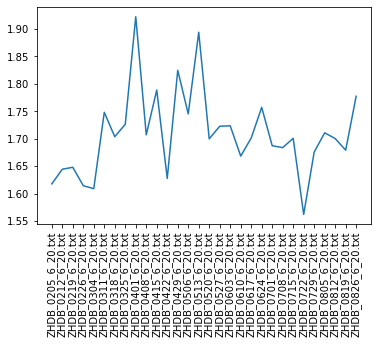

In [12]:
#Durchschnittlicher Abstand in der Wartefläche
plt.plot(filenames, distance_in_area)
plt.xticks(rotation = "vertical")

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29],
 <a list of 30 Text major ticklabel objects>)

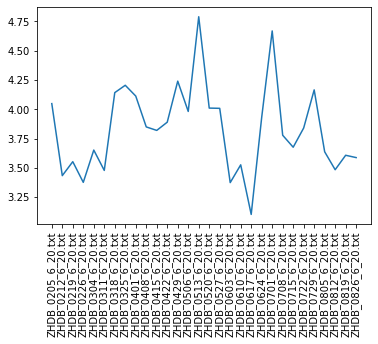

In [13]:
#Durchschnittlicher Abstand auf gesamten Bahnsteig
plt.plot(filenames, distance_out_area)
plt.xticks(rotation = "vertical")

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29],
 <a list of 30 Text major ticklabel objects>)

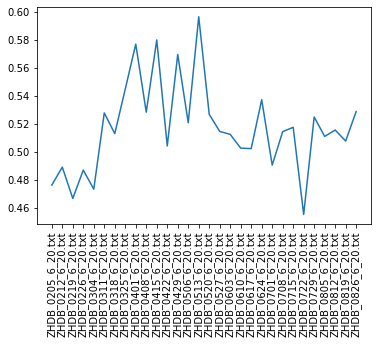

In [14]:
#Relativer Anteil von Abständen mit mehr als 1.5 Metern innerhalb der Fläche
plt.plot(filenames, keep_distance)
plt.xticks(rotation = "vertical")

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29],
 <a list of 30 Text major ticklabel objects>)

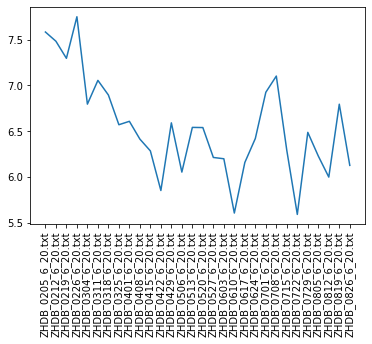

In [15]:
#Zeit für Einstieg ganzer Wartetraube -> Muss noch korrigiert werden, da pauschal 5 Sekunden abgezogen werden
plt.plot(filenames, enterTimeAverage)
plt.xticks(rotation = "vertical")

In [18]:
# enterTimeAll sind alle Einstiegslängen zu jeder Traube
timeDf = pd.DataFrame()
allTimes = []
for enterTime in enterTimeAll:
    time = list(pd.Series(enterTime).value_counts().sort_index().index)
    for i in time:
        if i not in allTimes:
            allTimes.append(i)
timeDf["TimeOfBoarding"] = allTimes
for enterTime in enterTimeAll:
    time = list(pd.Series(enterTime).value_counts().sort_index().index)
    number = list(pd.Series(enterTime).value_counts().sort_index())
    selectDf = pd.DataFrame()
    selectDf["TimeOfBoarding"] = time
    selectDf["numbers"] = number
    break
selectDf

#HIER WERDEN MOMENTAN FALSCHE ZEITEN ANGEZEIGT

,TimeOfBoarding,numbers
0,2,2
1,3,1
2,4,2
3,5,8
4,6,10
5,7,5
6,8,4
7,9,3
8,10,3
9,11,1


In [19]:
allTimes

[2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 18,
 25,
 0,
 19,
 21,
 20,
 42,
 17,
 1,
 -2,
 -1,
 22,
 23,
 -3,
 26]